Dataset created and saved as 'synthetic_dynamic_pricing_data.csv'


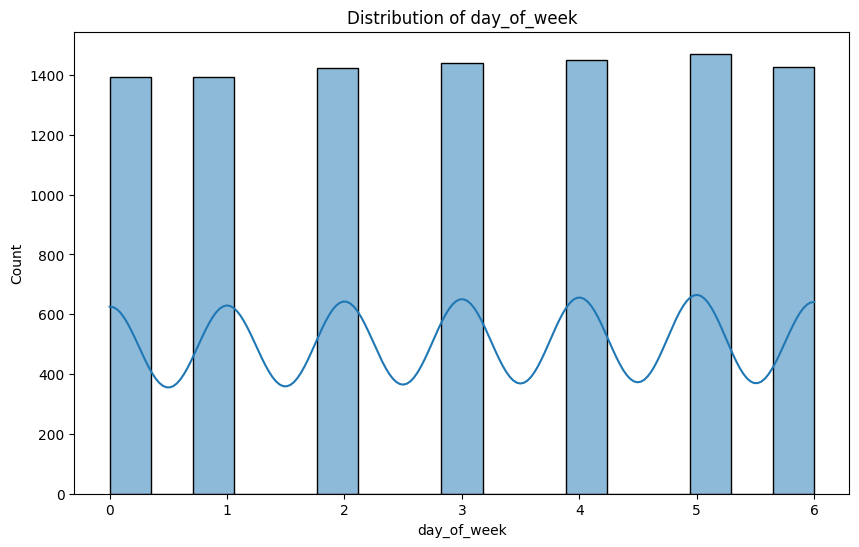

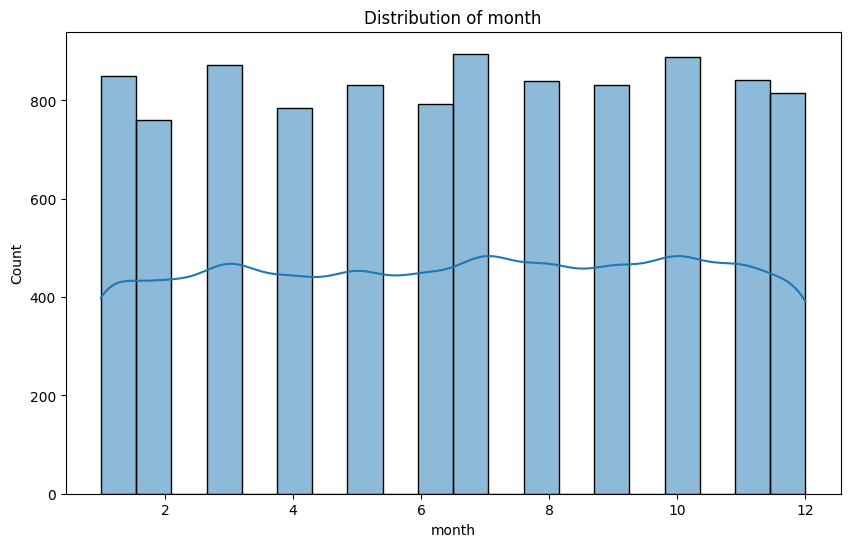

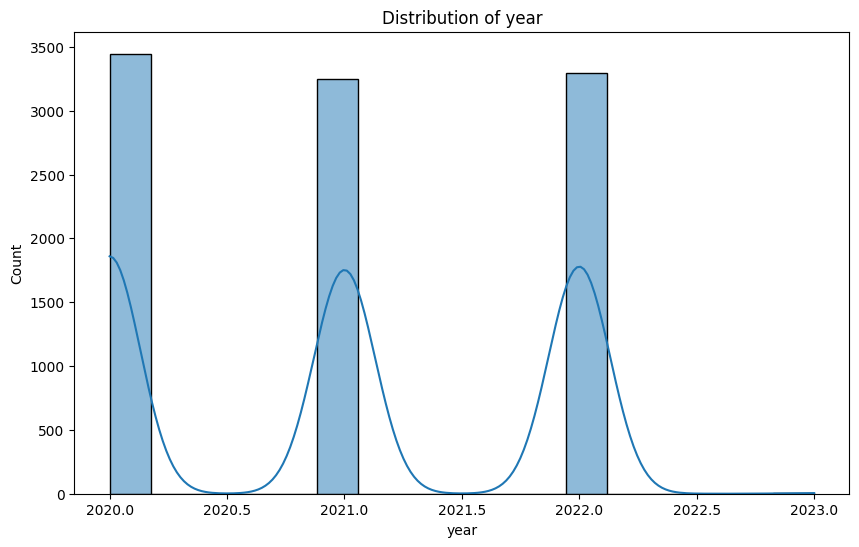

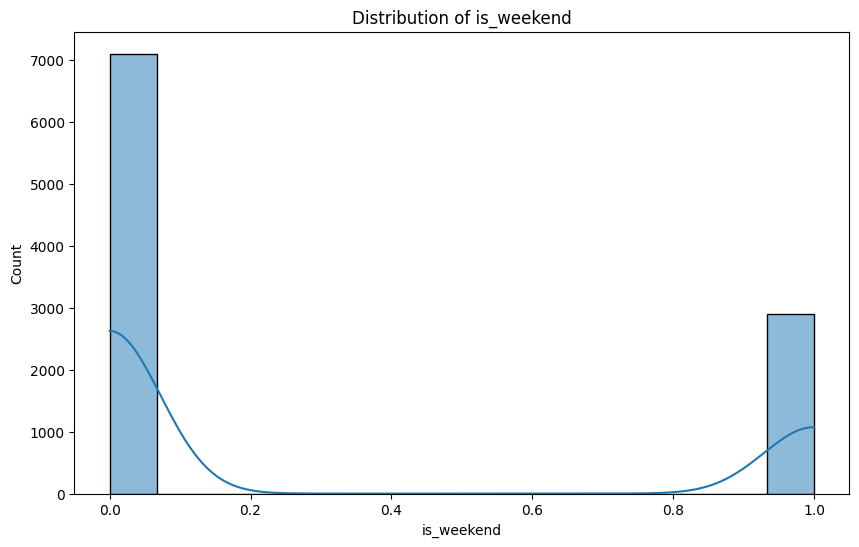

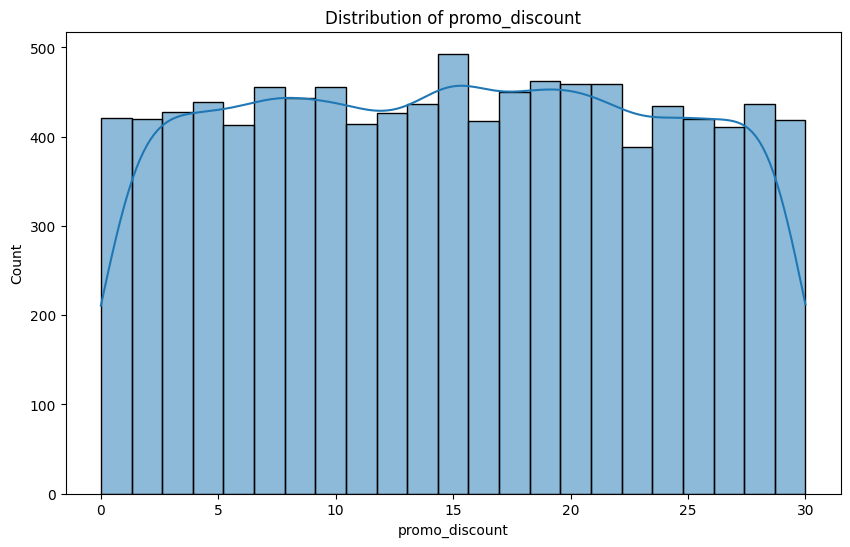

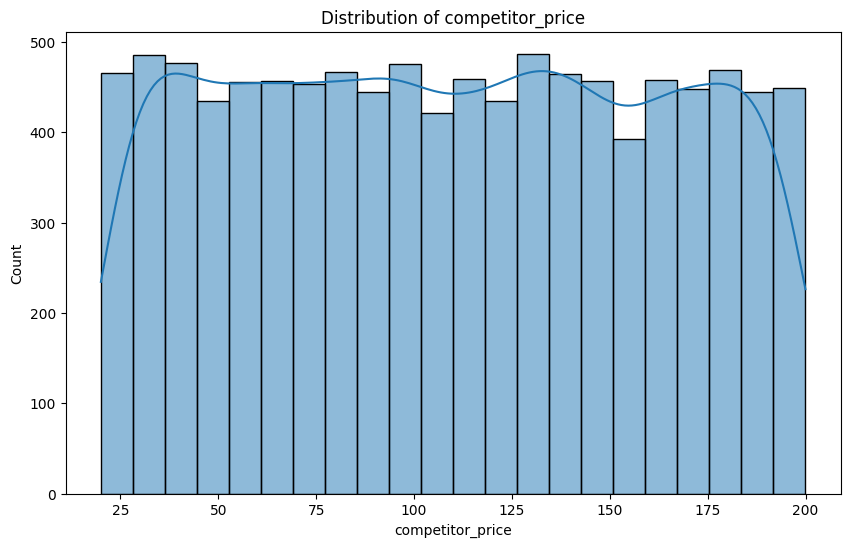

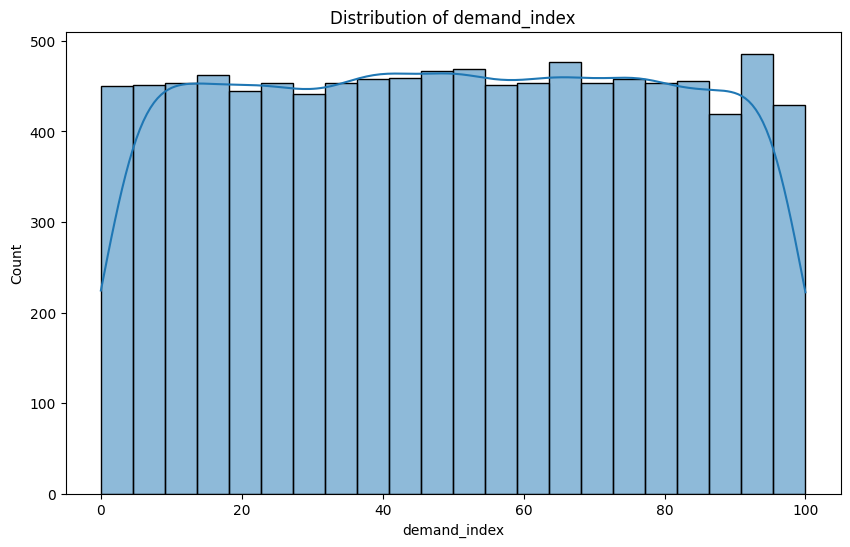

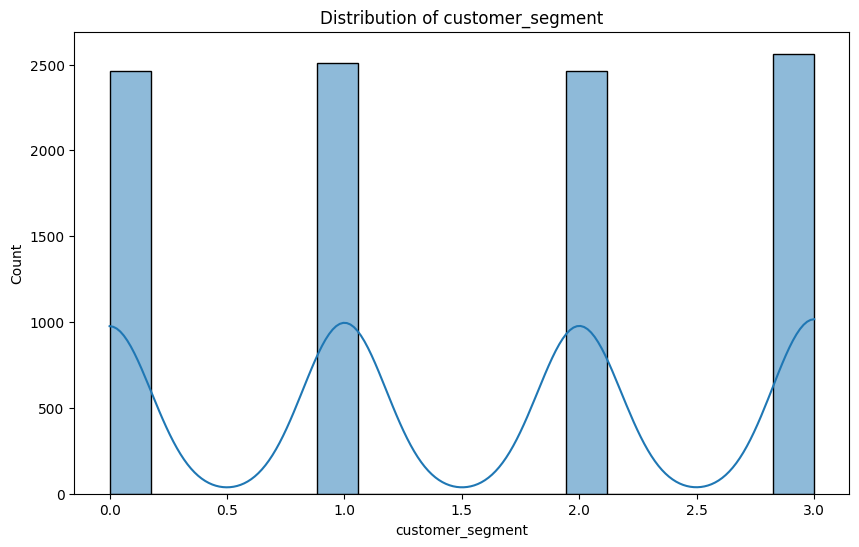

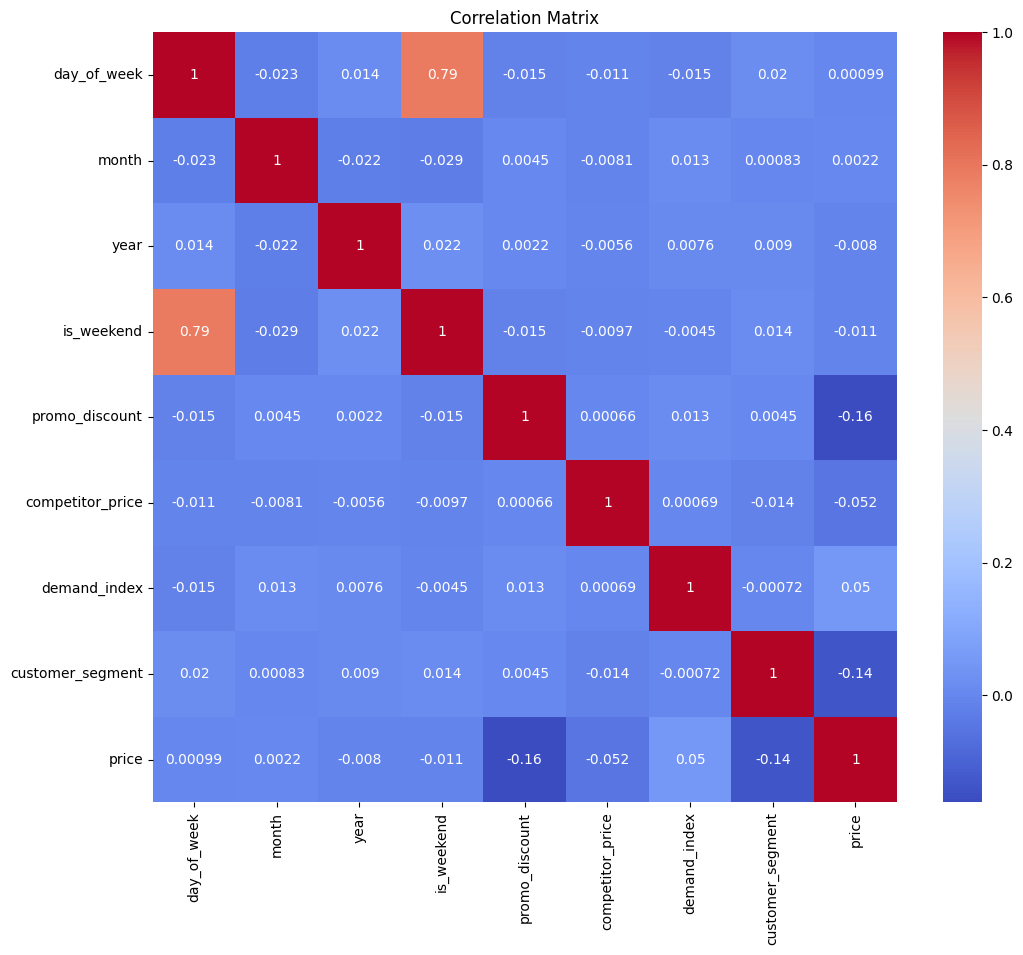

Gradient Boosting MAE: 45.76491307460607, RMSE: 52.68025023034614
XGBoost MAE: 45.82490307291667, RMSE: 52.70818586040693
 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with stat


SystemExit: 1

D:\PYTHON\Lib\site-packages\IPython\core\interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib
from flask import Flask, request, jsonify

# Step 1: Generate Synthetic Dataset

# Function to generate random dates
def random_date(start, end):
    return start + timedelta(days=random.randint(0, int((end - start).days)))

# Generate synthetic data
np.random.seed(42)
random.seed(42)

n_samples = 10000
start_date = datetime.strptime('2020-01-01', '%Y-%m-%d')
end_date = datetime.strptime('2023-01-01', '%Y-%m-%d')

data = []
for _ in range(n_samples):
    date = random_date(start_date, end_date)
    day_of_week = date.weekday()
    month = date.month
    year = date.year
    is_weekend = 1 if day_of_week >= 5 else 0
    promo_discount = round(np.random.uniform(0, 30), 2)
    competitor_price = round(np.random.uniform(20, 200), 2)
    demand_index = round(np.random.uniform(0, 100), 2)
    customer_segment = random.choice(['A', 'B', 'C', 'D'])
    base_price = round(np.random.uniform(20, 200), 2)
    
    # Price influenced by various factors
    price = base_price - promo_discount + (0.1 * demand_index) + (0.05 * (200 - competitor_price)) 
    if customer_segment == 'A':
        price *= 1.1
    elif customer_segment == 'B':
        price *= 1.05
    elif customer_segment == 'C':
        price *= 0.95
    else:
        price *= 0.9
    price = round(price, 2)

    data.append([date, day_of_week, month, year, is_weekend, promo_discount, competitor_price, demand_index, customer_segment, price])

# Create DataFrame
columns = ['date', 'day_of_week', 'month', 'year', 'is_weekend', 'promo_discount', 'competitor_price', 'demand_index', 'customer_segment', 'price']
df = pd.DataFrame(data, columns=columns)

# Save to CSV
df.to_csv('synthetic_dynamic_pricing_data.csv', index=False)

print("Dataset created and saved as 'synthetic_dynamic_pricing_data.csv'")

# Step 2: Load the Synthetic Dataset
data = pd.read_csv('synthetic_dynamic_pricing_data.csv')

# Step 3: Data Preprocessing
# Fill missing values if any
data.fillna(method='ffill', inplace=True)

# Feature Engineering
data['day_of_week'] = pd.to_datetime(data['date']).dt.dayofweek
data['month'] = pd.to_datetime(data['date']).dt.month
data['year'] = pd.to_datetime(data['date']).dt.year
data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
data['promo_discount'] = data['promo_discount']
data['competitor_price'] = data['competitor_price']
data['demand_index'] = data['demand_index']
data['customer_segment'] = data['customer_segment'].apply(lambda x: ord(x) - ord('A'))

# Select relevant features
features = ['day_of_week', 'month', 'year', 'is_weekend', 'promo_discount', 'competitor_price', 'demand_index', 'customer_segment']
target = 'price'

# Split dataset into training and testing sets
X = data[features]
y = data[target]
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

# Step 4: Exploratory Data Analysis (EDA)
# Plot feature distributions
for feature in features:
    plt.figure(figsize=(10, 6))
    sns.histplot(data[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()

# Correlation matrix excluding 'date' column
plt.figure(figsize=(12, 10))
sns.heatmap(data.drop(columns=['date']).corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Step 5: Model Selection and Training

# Model 1: Gradient Boosting
gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)

# Model 2: XGBoost
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

# Hyperparameter tuning for Gradient Boosting
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
}

grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)
best_gb = grid_search.best_estimator_

# Hyperparameter tuning for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
}

grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=5, scoring='neg_mean_absolute_error')
grid_search_xgb.fit(X_train, y_train)
best_xgb = grid_search_xgb.best_estimator_

# Step 6: Model Evaluation
# Predictions
y_pred_gb = best_gb.predict(X_test)
y_pred_xgb = best_xgb.predict(X_test)

# Evaluation Metrics
mae_gb = mean_absolute_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print(f'Gradient Boosting MAE: {mae_gb}, RMSE: {rmse_gb}')
print(f'XGBoost MAE: {mae_xgb}, RMSE: {rmse_xgb}')

# Step 7: Deployment using Flask
# Save the best model
joblib.dump(best_xgb, 'dynamic_pricing_model.pkl')

app = Flask(__name__)
model = joblib.load('dynamic_pricing_model.pkl')

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json(force=True)
    features = [data['day_of_week'], data['month'], data['year'], data['is_weekend'], data['promo_discount'], data['competitor_price'], data['demand_index'], data['customer_segment']]
    features = np.array(features).reshape(1, -1)
    features = scaler.transform(features)
    
    prediction = model.predict(features)
    return jsonify({'predicted_price': prediction[0]})

if __name__ == '__main__':
    app.run(debug=True)
